# Hierarchical sparse coding networks

\begin{equation}
    \begin{cases}
        \pmb{s}^{(n)}_{L-1} &= \pmb{W}_L \pmb{s}^{(n)}_L + \pmb{z}^{(n)}_L & \text{ s.t. }  & \lVert \pmb{s}^{(n)}_L \rVert_0 < \alpha_L \text{ and } \pmb{s}^{(n)}_L > 0  \\
        & \vdots \\ 
        \pmb{s}^{(n)}_{1} &= \pmb{W}_2 \pmb{s}^{(n)}_2 + \pmb{z}^{(n)}_2 & \text{ s.t. }  & \lVert \pmb{s}^{(n)}_2 \rVert_0 < \alpha_2 \text{ and } \pmb{s}^{(n)}_2 > 0  \\
        \pmb{y}^{(n)} &= \pmb{W}_1 \pmb{s}^{(n)}_1 + \pmb{z}^{(n)}_1 & \text{ s.t. }  & \lVert \pmb{s}^{(n)}_1 \rVert_0 < \alpha_1 \text{ and } \pmb{s}^{(n)}_1 > 0 
    \end{cases}
\end{equation}

# Bayesian sparse coding

\begin{equation}
 \begin{split}
    \pmb{u}^{(n)} & \sim Exp(\lambda) \\
    \pmb{s}^{(n)} &= ReLU(\pmb{u}^{(n)} - \gamma) \\
    \pmb{y}^{(n)} &= \pmb{W} \pmb{s}^{(n)} + \pmb{z}^{(n)}
 \end{split}
\end{equation}

or approximately 

\begin{equation}
 \begin{split}
    \pmb{v}^{(n)} & \sim \mathcal{N}\left(0, \mathbb{I} \right) \\
    \pmb{s}^{(n)} &= ReLU( f\left(\pmb{v}^{(n)}\right) - \gamma) \\
    \pmb{y}^{(n)} &= \pmb{W} \pmb{s}^{(n)} + \pmb{z}^{(n)}
 \end{split}
\end{equation}

where $f(x) = \ln \left( 1 + e^{-a \cdot x}  \right)$, and $a = 1.702$.

\begin{equation}
 \begin{split}
    \langle s_i^{(n)} \rangle &= e^{- \lambda \gamma} = \pi ^ \lambda \\
    Var\left( s_i^{(n)} \right) &= \pi^2 + 2 \frac{\pi^\lambda}{\lambda} \left( \frac{1}{\lambda} - \pi \right) = \rho ^ 2 \\
 \end{split}
\end{equation}



# Hierarchical Bayesian sparse coding

\begin{equation}
    \begin{cases}
        \pmb{v}^{(n)}_L & = \pmb{z}^{(n)}_L  \\
        \pmb{s}^{(n)}_L & = ReLU( f\left(\pmb{v}^{(n)}_L \right) - \gamma_L) - \pi_L^{\lambda_L} \\ 
        \pmb{v}^{(n)}_{L-1} &= \pmb{W}_L \pmb{s}^{(n)}_L + \pmb{z}^{(n)}_{L-1} \\
        & \vdots \\ 
        \pmb{v}^{(n)}_{1} &= \pmb{W}_2 \pmb{s}^{(n)}_2 + \pmb{z}^{(n)}_1 \\
        \sigma_{1i} &= \sqrt{ s_1^2 + \rho_L^2 \sum_j W_{ij}^2 } \\
        \pmb{s}^{(n)}_1 & = ReLU \left( f\left(\pmb{v}^{(n)}_1 / \pmb{\sigma}_1 \right) - \gamma_1 \right) - \pi_1^{\lambda_1} \\
        \pmb{y}^{(n)} &= \pmb{W}_1 \pmb{s}^{(n)}_1 + \pmb{z}^{(n)}_0 
    \end{cases}
\end{equation}

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
####################
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from functools import partial
from jax import random, vmap, nn
from jax.nn import one_hot
from flax import linen as fnn
from typing import Any, Callable, Sequence, Optional

import optax
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, SVI, TraceGraph_ELBO, Predictive
from numpyro.infer.reparam import LocScaleReparam
from numpyro import handlers

sns.set(context='notebook')

rng_key = random.PRNGKey(3478)

In [3]:
from jax import jit, grad
from jax.scipy.special import erf

@jit
def f(x, a=1.702):
    z = nn.sigmoid(a * x)  # approx for 0.5 * ( 1 + erf(x/jnp.sqrt(2)))
    return - jnp.log(z)

jit_grad_f = jit(grad(f))
print(jit_grad_f(-0.))

%timeit jit_grad_f(-0.)

-0.851
The slowest run took 35.56 times longer than the fastest. This could mean that an intermediate result is being cached.
797 µs ± 973 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
def global_vars(d, k, m, layers):
    
    with numpyro.plate('layers', layers):
        gamma = numpyro.sample('gamma', dist.Gamma(1, 2).expand([layers]))
        sig = numpyro.sample('sig', dist.Gamma(1/2, 1).expand([layers, 2]).to_event(1))
        scale = numpyro.deterministic('scale', jnp.sqrt(sig[..., 0]/sig[..., 1]) )

        _lam = numpyro.sample('_lam', dist.Gamma(1/2, 1).expand([layers, 2]).to_event(1))
        lam = numpyro.deterministic('lam', jnp.sqrt(_lam[..., 0]/_lam[..., 1]))
        
        _tau = numpyro.sample('_tau', dist.Gamma(1/2, 1).expand([layers, 2, d]).to_event(2))
        tau = numpyro.deterministic('tau', jnp.sqrt(_tau[:, 0]/_tau[:, 1]))

        s = .5 * jnp.expand_dims(lam, -1) * tau
    if layers > 1:
        with numpyro.plate('weights', layers - 1):
            _W = numpyro.sample('_W_base', dist.Normal(0, 1).expand([layers - 1, d, d]).to_event(2))
            W = numpyro.deterministic('W', jnp.expand_dims(s[:-1], -1) * _W)
        W = list(W)
    else:
        W = []

    _W = numpyro.sample('W1_base', dist.Normal(0, 1).expand([d, k*m]).to_event(2))
    W1 = numpyro.deterministic('W1', jnp.expand_dims(s[-1], (-1, -2)) * _W.reshape(d, k, m))

    return W + [W1], scale, gamma

def local_vars(W, v, scale, gamma, l, imgs=None):
    shape = W.shape
    d = shape[0]

    # mean 
    pi = jnp.exp( - gamma)

    # standard deviation 
    rho_square = pi * (2 - pi)
    W = W.reshape(d, -1)
    std = jnp.sqrt(scale ** 2 + rho_square * jnp.square(W).sum(0))

    s = numpyro.deterministic(f's_{l}', nn.relu( f(v) - gamma ) )
    loc = numpyro.deterministic(f'loc_{l}', ((s - pi) @ W).reshape( (-1,) + shape[1:] ) )

    if l > 1:
        with handlers.reparam(config={f'v_{l-1}': LocScaleReparam(0)}):
            v = numpyro.sample(f'v_{l-1}', dist.Normal(loc, scale).to_event(len(shape[1:])))
            v_norm = numpyro.deterministic(f'v_normalized_{l-1}', v / std)
        return v_norm
    else:
        numpyro.sample(f'v_{l-1}', dist.Normal(loc, scale).to_event(len(shape[1:])), obs=imgs)
        return None

def model(images=None, layers=1, n=100, d=16, k=8, m=8, subsample_size=None):
    Ws, scales, gammas = global_vars(d, k, m, layers)

    with numpyro.plate('data', n, subsample_size=subsample_size):
        batch_imgs = images if images is None else numpyro.subsample(images, event_dim=2)
        v = numpyro.sample(f'v_{layers}', dist.Normal(0, 1.).expand([n, d]).to_event(1))
        for l in range(layers):
            if l == layers - 1:
                local_vars(Ws[l], v, scales[l], gammas[l], layers-l, imgs=batch_imgs)
            else:
                v = local_vars(Ws[l], v, scales[l], gammas[l], layers-l)

def log_normal(name, shape, event_dim):
    loc = numpyro.param(f'loc.{name}', jnp.zeros(shape))
    scale = numpyro.param(f'scale.{name}', jnp.ones(shape)/10, constraint=constraints.softplus_positive)
    numpyro.sample(name, dist.LogNormal(loc, scale).to_event(event_dim))

def normal(name, shape, event_dim):
    loc = numpyro.param(f'loc.{name}', jnp.zeros(shape))
    scale = numpyro.param(f'scale.{name}', jnp.ones(shape)/10, constraint=constraints.softplus_positive)
    numpyro.sample(name, dist.Normal(loc, scale).to_event(event_dim))

def multivariate_normal(name, shape):
    assert len(shape) == 2
    n, d = shape
    loc = numpyro.param(f'loc.{name}', jnp.zeros(shape))
    scale_tril = numpyro.param(f'scale_tril.{name}', jnp.broadcast_to(jnp.eye(d), (n, d, d))/10, constraint=constraints.softplus_lower_cholesky)
    numpyro.sample(name, dist.MultivariateNormal(loc, scale_tril=scale_tril))

def global_guide(d, k, m, layers):
    with numpyro.plate('layers', layers):
        shape = (layers,)
        log_normal('gamma', shape, 0)

        shape = (layers, 2,)
        log_normal('sig', shape, 1)
        
        shape = (layers, 2,)
        log_normal('_lam', shape, 1)

        shape = (layers, 2, d)
        log_normal('_tau', shape, 2)

    if layers > 1:
        with numpyro.plate('weights', layers - 1):
            shape = (layers -1, d, d,)
            normal('_W_base', shape, 2)

    shape = (d, k * m,)
    normal('W1_base', shape, 2)

def local_guide(l, shape):
    name = f'v_{l}'
    multivariate_normal(name, shape)

def guide(images=None, layers=1, n=100, d=16, k=8, m=8, subsample_size=None):
    global_guide(d, k, m, layers)

    shape = (n, d)
    with numpyro.plate('data', n, subsample_size=subsample_size):
        for l in range(layers):    
            local_guide(layers-l, shape)


pred = Predictive(model, num_samples=1)
rng_key, key = random.split(rng_key)
layers = 5
sample = pred(key, layers=layers, n=200)

%timeit pred(key, layers=1)

334 ms ± 78.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


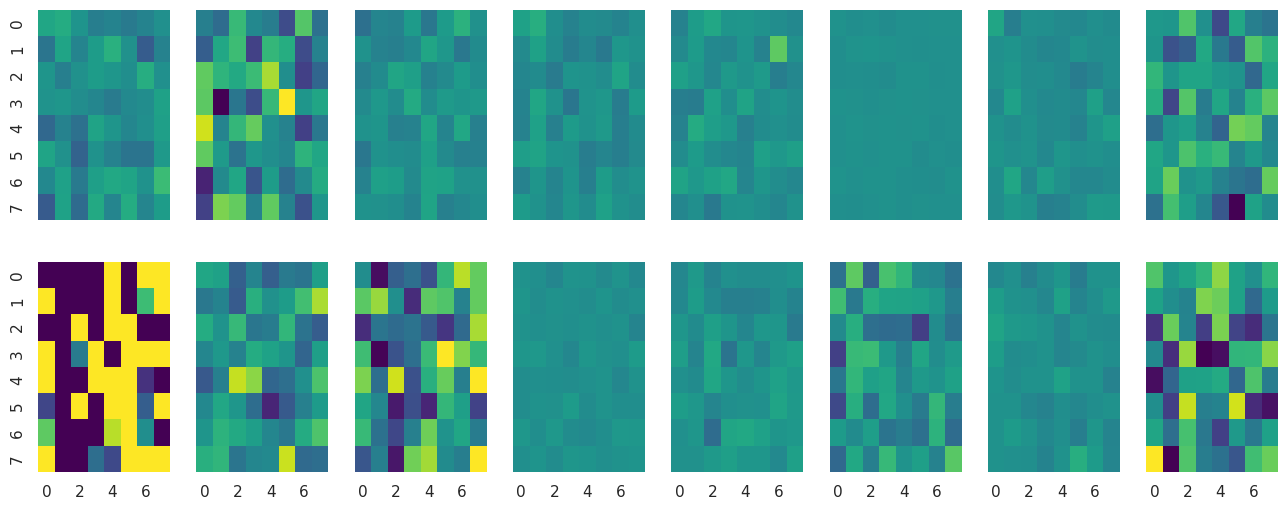

In [5]:
sample['W1'][0]

fig, axes = plt.subplots(2, 8, figsize=(16, 6), sharey=True, sharex=True)

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(sample['W1'][0][i], ax=ax, cmap='viridis', vmax=1, vmin=-1, cbar=False)

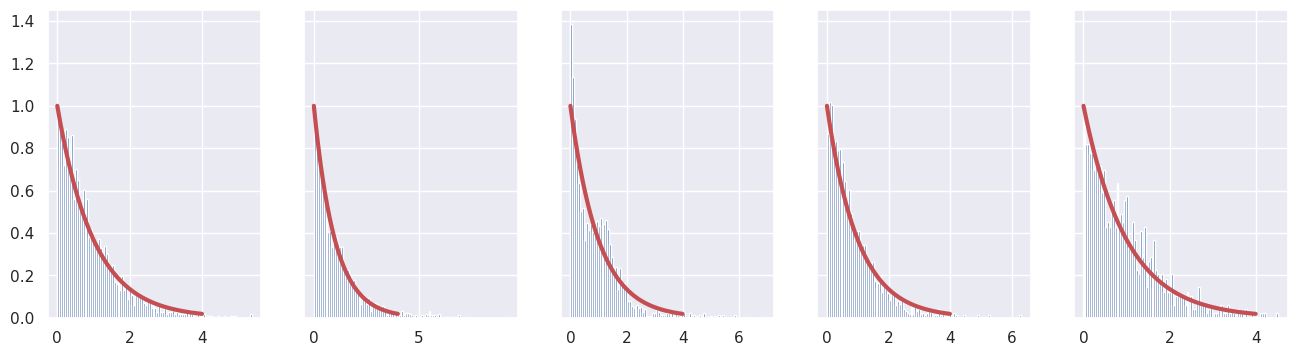

In [6]:
fig, axes = plt.subplots(1, layers, figsize=(16, 4), sharey=True)
for l in range(1, layers + 1):
    s = sample[f's_{l}'][0]
    axes[l - 1].hist(s[s > 0], bins=100, density=True);
    x = jnp.arange(0, 4, 0.01)
    gamma = sample['gamma'][0, -l]
    axes[l - 1].plot(x, jnp.exp( - x), 'r', lw=3)

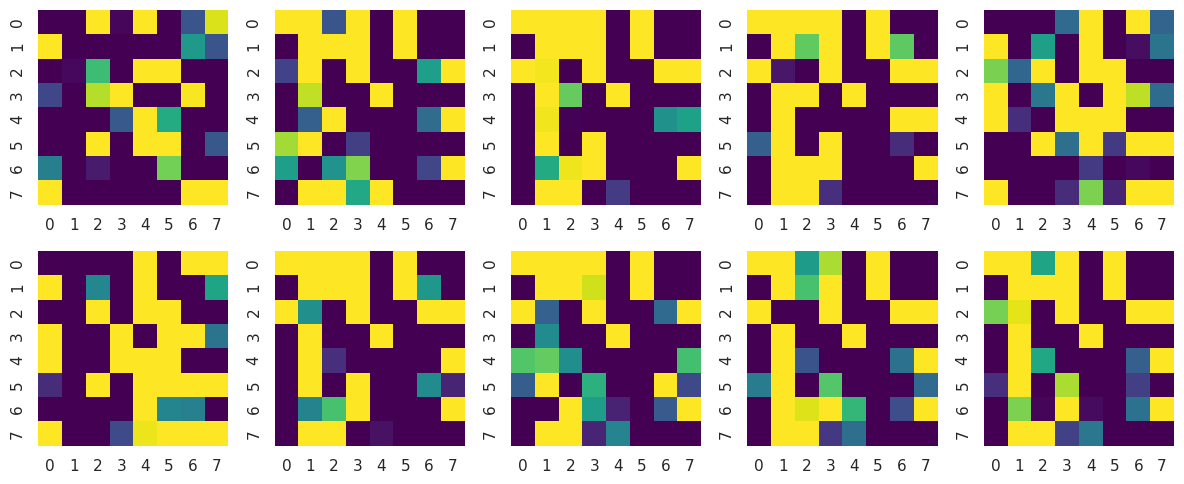

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

O = sample['v_0'][0]

for i, w in enumerate(O[:10]):
    sns.heatmap(w, ax=axes.flatten()[i], cbar=False, vmax=1, vmin=0, cmap='viridis')

fig.tight_layout()

In [8]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=900, num_samples=100)

rng_key, _rng_key = random.split(rng_key)
mcmc.warmup(_rng_key, collect_warmup=True, images=sample['v_0'][0], n=200, layers=layers, d=32)
warm_smpl = mcmc.get_samples()
rng_key, _rng_key = random.split(rng_key)
mcmc.run(random.PRNGKey(0), images=sample['v_0'][0], n=200, layers=layers, d=32)

post_smpl = mcmc.get_samples()

sample: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s, 1023 steps of size 4.46e-04. acc. prob=0.89]


In [15]:
post_smpl.keys()

dict_keys(['W', 'W1', 'W1_base', '_W_base', '_lam', '_tau', 'gamma', 'lam', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5', 's_1', 's_2', 's_3', 's_4', 's_5', 'scale', 'sig', 'tau', 'v_1', 'v_1_decentered', 'v_2', 'v_2_decentered', 'v_3', 'v_3_decentered', 'v_4', 'v_4_decentered', 'v_5', 'v_normalized_1', 'v_normalized_2', 'v_normalized_3', 'v_normalized_4'])

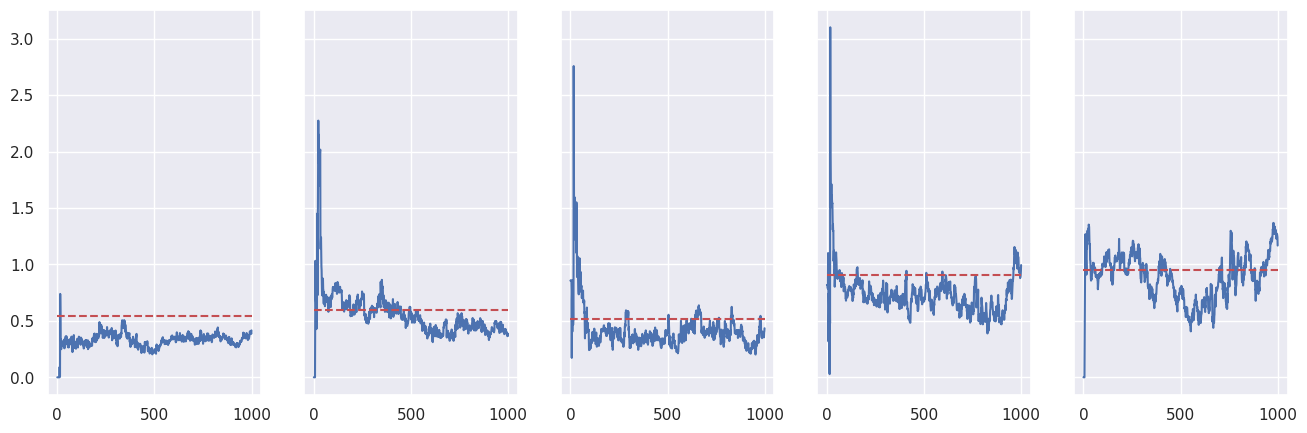

In [16]:
n = 0
pi = jnp.exp(- post_smpl['gamma']).mean(0)

fig, axes = plt.subplots(1, layers, figsize=(16, 5), sharex=True, sharey=True)

for l, ax in enumerate(axes):
    ax.plot( jnp.concatenate([warm_smpl[f's_{l+1}'][:, n].mean(-1), post_smpl[f's_{l+1}'][:, n].mean(-1)]) )
    ax.hlines(pi[ -l-1], 0, 1000, 'r', linestyle='--')

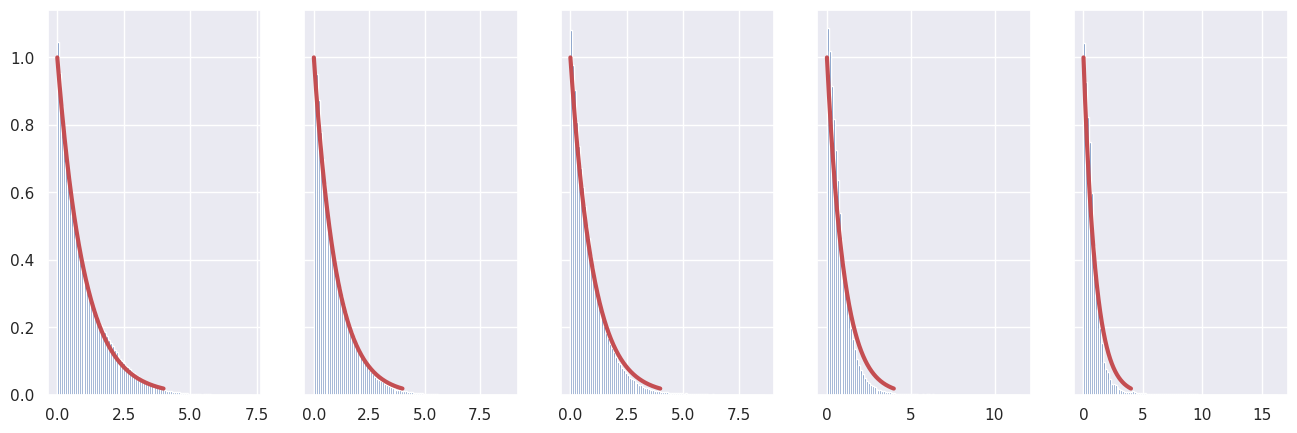

In [17]:
fig, axes = plt.subplots(1, layers, figsize=(16, 5), sharey=True)

for l in range(layers):
    axes[l].hist(post_smpl[f's_{layers - l}'][post_smpl[f's_{layers - l}'] > 0], bins=100, density=True);
    x = jnp.arange(0, 4, 0.01)
    axes[l].plot(x, jnp.exp(- x), 'r', lw=3)

In [23]:
post_smpl['v_4_decentered'][:, 0]

2023-06-16 08:36:04.496824: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:770] failed to free device memory at 0x7fb7ac623a00; result: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure
2023-06-16 08:36:04.496860: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: INTERNAL: Failed to complete all kernels launched on stream 0x55e8cf7bbca0: Could not synchronize CUDA stream: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure


XlaRuntimeError: INTERNAL: Failed to complete all kernels launched on stream 0x55e8cf7bbca0: Could not synchronize CUDA stream: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure

In [18]:
optim = numpyro.optim.optax_to_numpyro(optax.adabelief(1e-3))
svi = SVI(model, guide, optim, TraceGraph_ELBO(num_particles=1))

rng_key, key = random.split(rng_key)
results = svi.run(key, 50_000, images=sample['v_0'][0], n=200, layers=layers, d=32)

100%|██████████| 50000/50000 [01:56<00:00, 429.46it/s, init loss: 179546.8594, avg. loss [47501-50000]: -205965.8125]


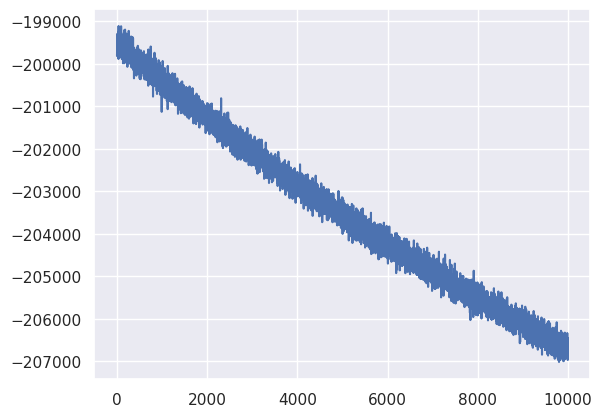

In [19]:
plt.plot(results.losses[-10_000:])

In [20]:
pred = Predictive(cm, guide=guide, params=results.params, num_samples=100)

rng_key, key = random.split(rng_key)
svi_samples = pred(key, n=200, layers=layers, d=32)

NameError: name 'cm' is not defined

/home/dima/.conda/envs/numpc/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


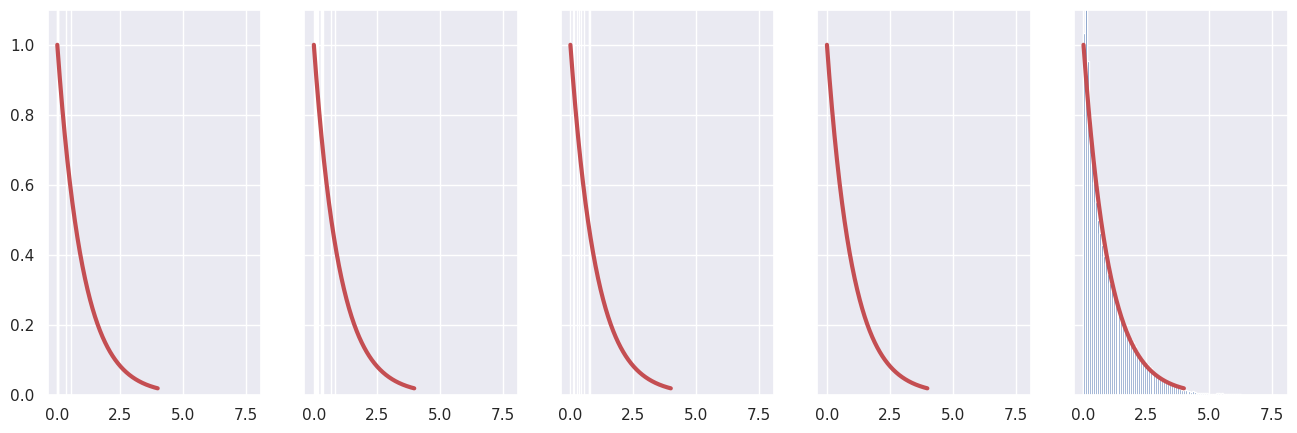

In [ ]:
fig, axes = plt.subplots(1, layers, figsize=(16, 5), sharey=True, sharex=True)

for l in range(layers):
    axes[l].hist(svi_samples[f's_{layers - l}'][svi_samples[f's_{layers - l}'] > 0], bins=100, density=True);
    x = jnp.arange(0, 4, 0.01)
    axes[l].plot(x, jnp.exp(- x), 'r', lw=3)
    axes[l].set_ylim([0, 1.1])

#TODO test posterior shape for a single shape and define a scheme for approximate posterior